<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2: Knowledge Distillation in MHIST Dataset**

# Question 1

(a). MHIST dataset contains images of colorectal polyps. Both pre-trained ResNet50 and pre-trained MobileNetV2 do not possess the capability to classify colorectal polyps, as ImageNet does not contain any colorectal polyps examples. However, the first few layers of DNN, especially those trained on ImageNet, can usually capture general features in images like edges, textures, and shapes. These features are often generic and can be beneficial for many other visual classification tasks. By using the architecture of ResNet50 or MobileNetV2 and their trained weights, we can leverage their already-learned primitive features identifiers for our tasks. In addition, the final layer of DNNs is usually customized for the dataset they are trained on. For example, different dataset may contain different number of classes, and thus having different number of neurons in their last layers. By leveraging fine-tuning processes, even though the MHIST dataset have different classes than ImageNet, we can replace the output layer of ResNet50 and MobileNetV2 with custom layers tailored for MHIST, then freeze the per-trained layers and fine-tunes the parameters on those custom layers based on the MHIST dataset.

(b). Residual block is a fundamental unit in Residual Network architecutres. It usually contains 2 convolutional layers with batch normalization layer attached after each, activation functions, and most importantly a residual path that connect the input of block to the output, creating skip connection.

(c). Compared to ResNetV1 which has the following order within the residual block: Conv -> BN -> ReLU, the order within the residual block has changed to: BN -> ReLU -> Conv in ResNetV2. In addtion, in ResNetV1, ReLU activation is applied after the addition of the residual path. In ResNetV2, no activation is applied after addition.

(d). MobileNetV1 used depthwise separable convolutions to reduce computational cost and build lightweight DNNs. MobileNetV2 build upon this by adding linear bottlenecks between the layers and connecting bottlenecks with residual path, which forms an inverted residual block.

(e). This is due to the presence of residual connection in the residual block. For example, we can express the function in residual block as $f(x) + x$, where $f(x)$ is the function performed by the original layers and $+ x$ is the residual connection in the block. If we take the derivative of $f(x) + x$ with respect to $x$, we will get $\frac{d}{dx} f(x) + 1$. The vanishing gradient problem is usually occured during backpropogation where gredients are repeatedly multiplied by some small number during the backpropogation along the $f(x)$ path, i.e., $\frac{d}{dx} f(x)$. The $+ 1$ gives the backpropogated gradient a path to avoid the processing done in $f(x)$ and flow uninterruptly, which essentially mitigate the problem of vanishing gradient.

(f). MobileNetV2 is considered as a lightweight model. It and its predecessor MobileNetV1 are designed for mobile devices with limited computation resources. Thus, its architecture, such as depthwise separable convolutions and inverted residual blocks, are tailored to reduce the number of FLOPs and parameters required to make prediction and provide a good balance between performance and computational efficiency.

# Question 2

**Load dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Project_A_Supp/mhist_dataset

# !unzip images.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Project_A_Supp/mhist_dataset


In [3]:
import pandas as pd

annotations = pd.read_csv('annotations.csv')
annotations.head(10)

Image Name Majority Vote Label  \
0  MHIST_aaa.png                 SSA   
1  MHIST_aab.png                  HP   
2  MHIST_aac.png                 SSA   
3  MHIST_aae.png                  HP   
4  MHIST_aaf.png                 SSA   
5  MHIST_aag.png                  HP   
6  MHIST_aah.png                  HP   
7  MHIST_aai.png                  HP   
8  MHIST_aaj.png                  HP   
9  MHIST_aak.png                  HP   

   Number of Annotators who Selected SSA (Out of 7) Partition  
0                                                 6     train  
1                                                 0     train  
2                                                 5     train  
3                                                 1     train  
4                                                 5     train  
5                                                 2      test  
6                                                 2      test  
7                                                 3     train  
8                                                 0     train  
9                                                 2     train

In [4]:
train_annotations = annotations[annotations['Partition'] == 'train']
train_annotations.head()

Image Name Majority Vote Label  \
0  MHIST_aaa.png                 SSA   
1  MHIST_aab.png                  HP   
2  MHIST_aac.png                 SSA   
3  MHIST_aae.png                  HP   
4  MHIST_aaf.png                 SSA   

   Number of Annotators who Selected SSA (Out of 7) Partition  
0                                                 6     train  
1                                                 0     train  
2                                                 5     train  
3                                                 1     train  
4                                                 5     train

In [5]:
test_annotations = annotations[annotations['Partition'] == 'test']
test_annotations.head()

Image Name Majority Vote Label  \
5   MHIST_aag.png                  HP   
6   MHIST_aah.png                  HP   
14  MHIST_aaq.png                 SSA   
15  MHIST_aar.png                  HP   
22  MHIST_aay.png                  HP   

    Number of Annotators who Selected SSA (Out of 7) Partition  
5                                                  2      test  
6                                                  2      test  
14                                                 5      test  
15                                                 0      test  
22                                                 1      test

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MHISTDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')

        label = self.annotations.iloc[index, 1]
        # 0 for SSA, 1 for HP
        label = 0 if label == "SSA" else 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of subprocesses to use for data loading
num_workers = 2
# How many samples per batch to load
# batch_size = 32

# Load the training dataset without any normalization
train_dataset_raw = MHISTDataset(annotations=train_annotations, img_dir='./images/', transform=transforms.ToTensor())

# Compute the mean and std
means = torch.zeros(3).to(device)
stds = torch.zeros(3).to(device)
for img, _ in train_dataset_raw:
    img = img.to(device)  # Transfer image to GPU
    means += torch.mean(img, dim=(1,2))
    stds += torch.std(img, dim=(1,2))

means /= len(train_dataset_raw)
stds /= len(train_dataset_raw)

means = means.cpu()
stds = stds.cpu()

# Define plain transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# Define training data transformation with computed mean and std values
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

# define test data transformation with computed mean and std values
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_dataset = MHISTDataset(annotations=train_annotations, img_dir='./images/', transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

test_dataset = MHISTDataset(annotations=test_annotations, img_dir='./images/', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [8]:
print("Number of samples in training set:", len(train_dataset))
print("Number of samples in test set:", len(test_dataset))

# Fetch a single sample (image and label) from the training dataset
image, label = train_dataset[0]
# Each image has shape: [channels, height, width]
print("Shape of the image:", image.shape)

Number of samples in training set: 2175
Number of samples in test set: 977
Shape of the image: torch.Size([3, 224, 224])


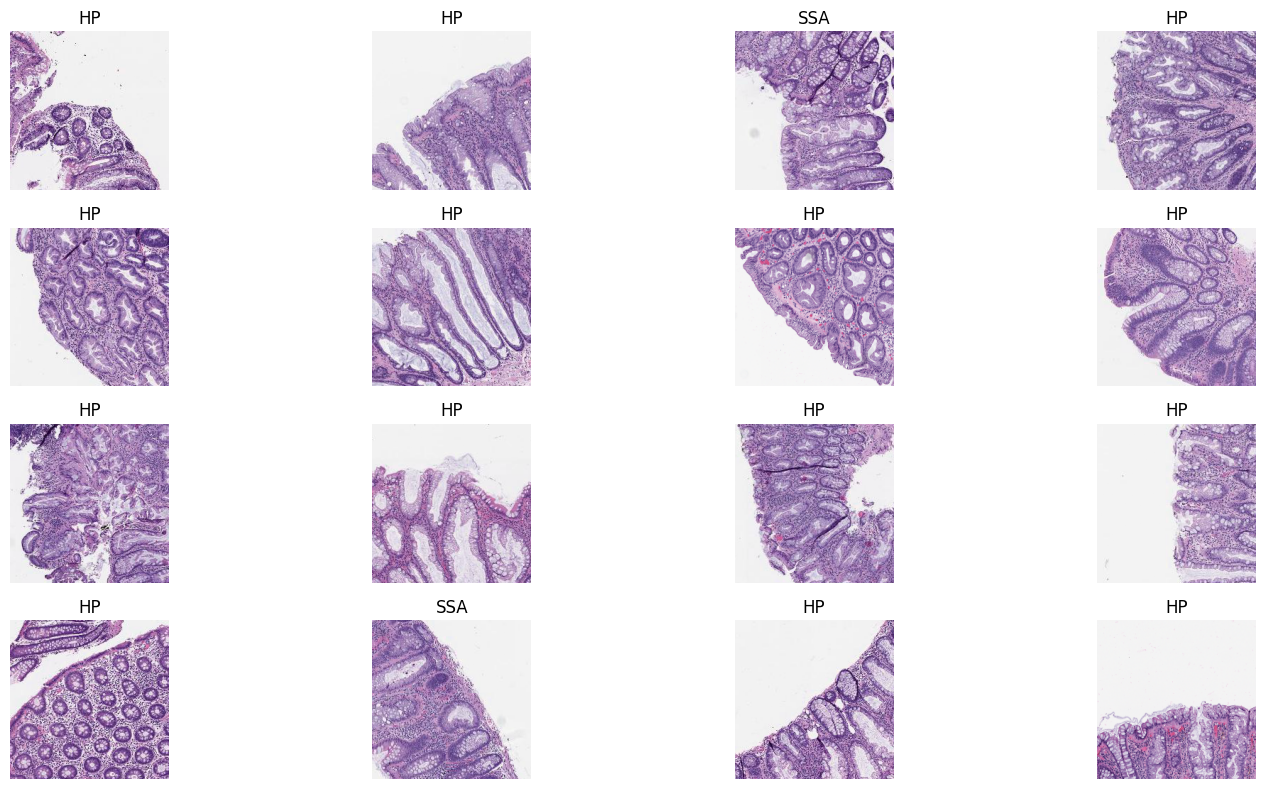

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and display an image
def imshow(ax, img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert from Tensor image and ensure it's on CPU
    # Unnormalize the image
    img = stds * img + means
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1 to display correctly
    ax.imshow(img)
    ax.axis('off')

# Get a batch of images and labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Convert labels back to their string representation for visualization
label_map = {0: "SSA", 1: "HP"}
labels = [label_map[int(i)] for i in labels]

# Display images with labels
fig = plt.figure(figsize=(16, 8))
for idx in np.arange(16):  # Displaying first 16 images of the batch
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    imshow(ax, images[idx])
    ax.set_title(labels[idx])
plt.tight_layout()
plt.show()

**Model creation**

**ResNet50**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)

# Freeze the pertrained layers and only train the final fc layer
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze only the last residual block 'layer4'
for name, param in resnet50.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

num_classes = 2  # MHIST dataset only has 2 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

print(resnet50)

learning_rate_resnet50 = 0.0001
criterion = nn.CrossEntropyLoss()
resnet50_params_to_update = list(resnet50.layer4.parameters()) + list(resnet50.fc.parameters())
optimizer = optim.Adam(resnet50_params_to_update, lr=learning_rate_resnet50)

# Function to update learning rate
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Transfer learning on pre-trained RestNet50**

In [16]:
num_epochs = 25
test_loss_min = np.Inf # track change in validation loss

for epoch in range(1, num_epochs+1):

    # Track test loss
    test_loss = 0.0

    resnet50.train()

    for inputs, labels in train_dataloader:

        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(inputs)
        # Compute the batch loss
        loss = criterion(output, labels)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

    # Update learning rate
    if (epoch+1) % 5 == 0:
        learning_rate_resnet50 /= 3
        update_lr(optimizer, learning_rate_resnet50)

    resnet50.eval()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(inputs)
        # Calculate the batch loss
        loss = criterion(output, labels)
        # Update average validation loss
        test_loss += loss.item()*inputs.size(0)

    test_loss = test_loss/len(test_dataloader.dataset)
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, test_loss))

    # Save the current model if test loss has decreased
    if test_loss <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
        test_loss_min,
        test_loss))
        torch.save(resnet50.state_dict(), 'teacher_model_parameters.pth')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.454971
Test loss decreased (inf --> 0.454971).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.495910
Epoch: 3 	Test Loss: 0.404721
Test loss decreased (0.454971 --> 0.404721).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.459329
Epoch: 5 	Test Loss: 0.460313
Epoch: 6 	Test Loss: 0.415827
Epoch: 7 	Test Loss: 0.451849
Epoch: 8 	Test Loss: 0.452224
Epoch: 9 	Test Loss: 0.499169
Epoch: 10 	Test Loss: 0.446637
Epoch: 11 	Test Loss: 0.445865
Epoch: 12 	Test Loss: 0.483114
Epoch: 13 	Test Loss: 0.480941
Epoch: 14 	Test Loss: 0.482617
Epoch: 15 	Test Loss: 0.459868
Epoch: 16 	Test Loss: 0.464943
Epoch: 17 	Test Loss: 0.471867
Epoch: 18 	Test Loss: 0.469331
Epoch: 19 	Test Loss: 0.486229
Epoch: 20 	Test Loss: 0.469106
Epoch: 21 	Test Loss: 0.471899
Epoch: 22 	Test Loss: 0.471629
Epoch: 23 	Test Loss: 0.486391
Epoch: 24 	Test Loss: 0.473527
Epoch: 25 	Test Loss: 0.472751


**Evaluation on teacher model**

In [19]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

# Load model parameters
resnet50.load_state_dict(torch.load('teacher_model_parameters.pth'))

# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

all_labels = []  # Store all true labels
all_preds = []  # Store all model predictions
all_probs = []  # Store softmax probabilities for AUC score computation

resnet50.eval()

for inputs, labels in test_dataloader:

    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = resnet50(inputs)
    # Calculate the batch loss
    loss = criterion(output, labels)
    # Update average test loss
    test_loss += loss.item()*inputs.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # Compute test accuracy for each class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    # Store the softmax probabilities of class 1 (HP) for AUC score
    # probs = torch.nn.functional.softmax(output, dim=1)[:, 1].cpu().detach().numpy()

    # Extend the lists
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(pred.cpu().numpy())
    # all_probs.extend(probs)

# Average test loss
# test_loss = test_loss/len(test_dataloader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# Label names for MHIST dataset
classes = ["SSA", "HP"]

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# F1 scores for each class
f1_SSA = f1_score(all_labels, all_preds, pos_label=0)  # SSA is labeled as 0
f1_HP = f1_score(all_labels, all_preds, pos_label=1)  # HP is labeled as 1
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print('\nF1 Score for SSA: {:.6f}'.format(f1_SSA))
print('F1 Score for HP: {:.6f}'.format(f1_HP))
print('Weighted F1 Score: {:.6f}\n'.format(weighted_f1))

print(classification_report(all_labels, all_preds, digits=6))

# roc_auc = roc_auc_score(all_labels, all_probs)
# print('ROC AUC Score: {:.6f}'.format(roc_auc))

Test Accuracy of   SSA: 69% (250/360)
Test Accuracy of    HP: 90% (560/617)
Test Accuracy (Overall): 82% (810/977)

F1 Score for SSA: 0.749625
F1 Score for HP: 0.870241
Weighted F1 Score: 0.825797

              precision    recall  f1-score   support

           0   0.814332  0.694444  0.749625       360
           1   0.835821  0.907618  0.870241       617

    accuracy                       0.829069       977
   macro avg   0.825077  0.801031  0.809933       977
weighted avg   0.827903  0.829069  0.825797       977



F1 Score answers the question: "How well does the model balance precision and recall?" A higher F1 Score indicates a better balance and overall performance

In [22]:
# Initialize pretrained MobileNetV2 model
mobilenetv2_plain = models.mobilenet_v2(pretrained=True)

# Freeze all parameters
for param in mobilenetv2_plain.parameters():
    param.requires_grad = False

num_classes = 2  # MHIST dataset only has 2 classes

# Modify the classifier
mobilenetv2_plain.classifier[1] = nn.Linear(mobilenetv2_plain.classifier[1].in_features, num_classes)
mobilenetv2_plain = mobilenetv2_plain.to(device)

print(mobilenetv2_plain)

optimizer = optim.Adam(mobilenetv2_plain.classifier[1].parameters(), lr=0.001)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Transfer learning on pre-trained MobileNetV2**

In [23]:
num_epochs = 25
test_loss_min = np.Inf  # track change in validation loss

for epoch in range(1, num_epochs+1):

    # Track test loss
    test_loss = 0.0

    mobilenetv2_plain.train()

    for inputs, labels in train_dataloader:

        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = mobilenetv2_plain(inputs)
        # Compute the batch loss
        loss = criterion(output, labels)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

    mobilenetv2_plain.eval()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = mobilenetv2_plain(inputs)
        # Calculate the batch loss
        loss = criterion(output, labels)
        # Update average validation loss
        test_loss += loss.item()*inputs.size(0)

    test_loss = test_loss/len(test_dataloader.dataset)
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, test_loss))

    # Save the current model if test loss has decreased
    if test_loss <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
        test_loss_min,
        test_loss))
        torch.save(mobilenetv2_plain.state_dict(), 'plain_student_model_parameters.pth')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.561065
Test loss decreased (inf --> 0.561065).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.494642
Test loss decreased (0.561065 --> 0.494642).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.536279
Epoch: 4 	Test Loss: 0.659568
Epoch: 5 	Test Loss: 0.738950
Epoch: 6 	Test Loss: 0.677061
Epoch: 7 	Test Loss: 0.612878
Epoch: 8 	Test Loss: 0.615305
Epoch: 9 	Test Loss: 0.517182
Epoch: 10 	Test Loss: 0.764906
Epoch: 11 	Test Loss: 0.494426
Test loss decreased (0.494642 --> 0.494426).  Model Parameters Saved
Epoch: 12 	Test Loss: 0.697227
Epoch: 13 	Test Loss: 0.575057
Epoch: 14 	Test Loss: 0.642385
Epoch: 15 	Test Loss: 0.622410
Epoch: 16 	Test Loss: 0.558722
Epoch: 17 	Test Loss: 0.516302
Epoch: 18 	Test Loss: 0.785901
Epoch: 19 	Test Loss: 0.620637
Epoch: 20 	Test Loss: 0.500296
Epoch: 21 	Test Loss: 0.700470
Epoch: 22 	Test Loss: 0.593890
Epoch: 23 	Test Loss: 0.537824
Epoch: 24 	Test Loss: 0.697554
Epoch: 25 	Test Loss: 0.600889


**Evaluation on student model (from scratch)**



In [25]:
# Load model parameters
# Load model parameters
mobilenetv2_plain.load_state_dict(torch.load('plain_student_model_parameters.pth'))

# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

all_labels = []  # Store all true labels
all_preds = []  # Store all model predictions
all_probs = []  # Store softmax probabilities for AUC score computation

mobilenetv2_plain.eval()

for inputs, labels in test_dataloader:

    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = mobilenetv2_plain(inputs)
    # Calculate the batch loss
    loss = criterion(output, labels)
    # Update average test loss
    test_loss += loss.item()*inputs.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # Compute test accuracy for each class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    # Store the softmax probabilities of class 1 (HP) for AUC score
    # probs = torch.nn.functional.softmax(output, dim=1)[:, 1].cpu().detach().numpy()

    # Extend the lists
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(pred.cpu().numpy())
    # all_probs.extend(probs)

# Average test loss
# test_loss = test_loss/len(test_dataloader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# Label names for MHIST dataset
classes = ["SSA", "HP"]

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# F1 scores for each class
f1_SSA = f1_score(all_labels, all_preds, pos_label=0)  # SSA is labeled as 0
f1_HP = f1_score(all_labels, all_preds, pos_label=1)  # HP is labeled as 1
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print('\nF1 Score for SSA: {:.6f}'.format(f1_SSA))
print('F1 Score for HP: {:.6f}'.format(f1_HP))
print('Weighted F1 Score: {:.6f}\n'.format(weighted_f1))

print(classification_report(all_labels, all_preds, digits=6))

Test Accuracy of   SSA: 50% (183/360)
Test Accuracy of    HP: 87% (540/617)
Test Accuracy (Overall): 74% (723/977)

F1 Score for SSA: 0.590323
F1 Score for HP: 0.809595
Weighted F1 Score: 0.728799

              precision    recall  f1-score   support

           0   0.703846  0.508333  0.590323       360
           1   0.753138  0.875203  0.809595       617

    accuracy                       0.740020       977
   macro avg   0.728492  0.691768  0.699959       977
weighted avg   0.734975  0.740020  0.728799       977



**Knowledge distillation from teacher model(ResNet50) to student model(MobileNetV2)**

In [26]:
# Initialize pretrained MobileNetV2 model
mobilenetv2_distillation = models.mobilenet_v2(pretrained=True)

# Freeze all parameters
for param in mobilenetv2_plain.parameters():
    param.requires_grad = False

num_classes = 2  # MHIST dataset only has 2 classes

# Modify the classifier
mobilenetv2_distillation.classifier[1] = nn.Linear(mobilenetv2_distillation.classifier[1].in_features, num_classes)
mobilenetv2_distillation = mobilenetv2_distillation.to(device)

print(mobilenetv2_distillation)

criterion_hard = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2_distillation.classifier[1].parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [29]:
# Hyperparameters
alpha = 0.9  # Weight for hard label loss
temperature = 20.0  # Temperature for softening probability distributions

# Set teacher to evaluation mode
resnet50.eval()

test_loss_min = np.Inf  # track change in validation loss

for epoch in range(1, num_epochs+1):

    # Track test loss
    test_loss = 0.0

    mobilenetv2_distillation.train()

    for inputs, labels in train_dataloader:

        inputs, labels = inputs.to(device), labels.to(device)

        # Get teacher's outputs
        with torch.no_grad():
            teacher_outputs = resnet50(inputs)

        # Get student's outputs
        student_outputs = mobilenetv2_distillation(inputs)

        # Compute hard label loss
        loss_hard = criterion_hard(student_outputs, labels)

        # Compute soft label loss
        # Soften the probabilities of teacher and student outputs
        teacher_probs = torch.nn.functional.softmax(teacher_outputs / temperature, dim=1)
        student_probs = torch.nn.functional.softmax(student_outputs / temperature, dim=1)

        loss_soft = (teacher_probs * torch.log(student_probs + 1e-6)).sum(dim=1).mean()

        # Combine the two losses
        loss = alpha * loss_soft + (1 - alpha) * loss_hard

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mobilenetv2_distillation.eval()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = mobilenetv2_distillation(inputs)
        # Calculate the batch loss
        loss = criterion_hard(output, labels)
        # Update average validation loss
        test_loss += loss.item()*inputs.size(0)

    test_loss = test_loss/len(test_dataloader.dataset)
    print('Epoch: {} \tTest Loss: {:.6f}'.format(
        epoch, test_loss))

    # Save the current model if test loss has decreased
    if test_loss <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
        test_loss_min,
        test_loss))
        torch.save(mobilenetv2_distillation.state_dict(), 'distilled_student_model_parameters.pth')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.713136
Test loss decreased (inf --> 0.713136).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.867449
Epoch: 3 	Test Loss: 0.542060
Test loss decreased (0.713136 --> 0.542060).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.636846
Epoch: 5 	Test Loss: 0.742840
Epoch: 6 	Test Loss: 0.523908
Test loss decreased (0.542060 --> 0.523908).  Model Parameters Saved
Epoch: 7 	Test Loss: 0.565631
Epoch: 8 	Test Loss: 0.528193
Epoch: 9 	Test Loss: 0.596907
Epoch: 10 	Test Loss: 0.669724
Epoch: 11 	Test Loss: 0.718421
Epoch: 12 	Test Loss: 0.752773
Epoch: 13 	Test Loss: 0.773653
Epoch: 14 	Test Loss: 0.849167
Epoch: 15 	Test Loss: 0.594204
Epoch: 16 	Test Loss: 0.592622
Epoch: 17 	Test Loss: 0.693777
Epoch: 18 	Test Loss: 0.739492
Epoch: 19 	Test Loss: 0.502138
Test loss decreased (0.523908 --> 0.502138).  Model Parameters Saved
Epoch: 20 	Test Loss: 0.552884
Epoch: 21 	Test Loss: 0.741505
Epoch: 22 	Test Loss: 0.681256
Epoch: 23 	Test Loss: 0.664849
Epoch: 24 	Test Loss: 0.8

In [30]:
# Load model parameters
# Load model parameters
mobilenetv2_distillation.load_state_dict(torch.load('distilled_student_model_parameters.pth'))

# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

all_labels = []  # Store all true labels
all_preds = []  # Store all model predictions
all_probs = []  # Store softmax probabilities for AUC score computation

mobilenetv2_distillation.eval()

for inputs, labels in test_dataloader:

    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = mobilenetv2_distillation(inputs)
    # Calculate the batch loss
    loss = criterion(output, labels)
    # Update average test loss
    test_loss += loss.item()*inputs.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # Compute test accuracy for each class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    # Store the softmax probabilities of class 1 (HP) for AUC score
    # probs = torch.nn.functional.softmax(output, dim=1)[:, 1].cpu().detach().numpy()

    # Extend the lists
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(pred.cpu().numpy())
    # all_probs.extend(probs)

# Average test loss
# test_loss = test_loss/len(test_dataloader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# Label names for MHIST dataset
classes = ["SSA", "HP"]

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# F1 scores for each class
f1_SSA = f1_score(all_labels, all_preds, pos_label=0)  # SSA is labeled as 0
f1_HP = f1_score(all_labels, all_preds, pos_label=1)  # HP is labeled as 1
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print('\nF1 Score for SSA: {:.6f}'.format(f1_SSA))
print('F1 Score for HP: {:.6f}'.format(f1_HP))
print('Weighted F1 Score: {:.6f}\n'.format(weighted_f1))

print(classification_report(all_labels, all_preds, digits=6))

Test Accuracy of   SSA: 54% (196/360)
Test Accuracy of    HP: 83% (517/617)
Test Accuracy (Overall): 72% (713/977)

F1 Score for SSA: 0.597561
F1 Score for HP: 0.796610
Weighted F1 Score: 0.723266

              precision    recall  f1-score   support

           0   0.662162  0.544444  0.597561       360
           1   0.759178  0.837925  0.796610       617

    accuracy                       0.729785       977
   macro avg   0.710670  0.691185  0.697086       977
weighted avg   0.723430  0.729785  0.723266       977

